In [19]:
!git clone https://github.com/egemenozen1/Walmart-LSTM-Sales-Forecasting.git

fatal: destination path 'Walmart-LSTM-Sales-Forecasting' already exists and is not an empty directory.


In [20]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pyexpat import features

# LSTM model for time series forecasting
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Data scaling
from sklearn.preprocessing import MinMaxScaler

In [21]:
# Load each dataset with the correct file paths
train_df = pd.read_csv("/content/Walmart-LSTM-Sales-Forecasting/Data/train.csv")
test_df = pd.read_csv("/content/Walmart-LSTM-Sales-Forecasting/Data/test.csv")
features_df = pd.read_csv("/content/Walmart-LSTM-Sales-Forecasting/Data/features.csv")
stores_df = pd.read_csv("/content/Walmart-LSTM-Sales-Forecasting/Data/stores.csv")

In [22]:
# Display the first few rows of each dataset to understand their structure
print("Train Data")
print(train_df.head())
print(train_df.info())

print("\nTest Data")
print(test_df.head())
print(test_df.info())

print("\nFeatures Data")
print(features_df.head())
print(features_df.info())

print("\nStores Data")
print(stores_df.head())
print(stores_df.info())

Train Data
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None

Test Data
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  201

In [23]:
# Convert 'Date' column to datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

# Merge train data with features and stores data on 'Store' and 'Date' columns
train_merged = train_df.merge(features_df, on=['Store', 'Date'], how='left')
train_merged = train_merged.merge(stores_df, on='Store', how='left')

In [24]:
# Fill missing values with 0
train_merged.fillna(0, inplace=True)

In [25]:
# Select relevant features for scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(train_merged[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])

In [26]:
# Prepare data for LSTM model: using past 30 days to predict the next day's sales
X, y = [], []
sequence_length = 30
for i in range(sequence_length, len(scaled_features)):
    X.append(scaled_features[i-sequence_length:i])  # Past 30 days data as input
    y.append(scaled_features[i, 0])  # 'Weekly_Sales' as the target for the next day

In [27]:
# Display summary statistics for numerical columns in each dataframe
print("Train Data Summary")
print(train_df.describe())

print("\nFeatures Data Summary")
print(features_df.describe())

print("\nStores Data Summary")
print(stores_df.describe())


Train Data Summary
               Store           Dept                           Date  \
count  421570.000000  421570.000000                         421570   
mean       22.200546      44.260317  2011-06-18 08:30:31.963375104   
min         1.000000       1.000000            2010-02-05 00:00:00   
25%        11.000000      18.000000            2010-10-08 00:00:00   
50%        22.000000      37.000000            2011-06-17 00:00:00   
75%        33.000000      74.000000            2012-02-24 00:00:00   
max        45.000000      99.000000            2012-10-26 00:00:00   
std        12.785297      30.492054                            NaN   

        Weekly_Sales  
count  421570.000000  
mean    15981.258123  
min     -4988.940000  
25%      2079.650000  
50%      7612.030000  
75%     20205.852500  
max    693099.360000  
std     22711.183519  

Features Data Summary
             Store                 Date  Temperature   Fuel_Price  \
count  8190.000000                 8190  8190.00000

In [28]:
# Check for missing values in each dataframe
print("Missing values in train data:\n", train_df.isnull().sum())
print("Missing values in features data:\n", features_df.isnull().sum())
print("Missing values in stores data:\n", stores_df.isnull().sum())


Missing values in train data:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
Missing values in features data:
 Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64
Missing values in stores data:
 Store    0
Type     0
Size     0
dtype: int64


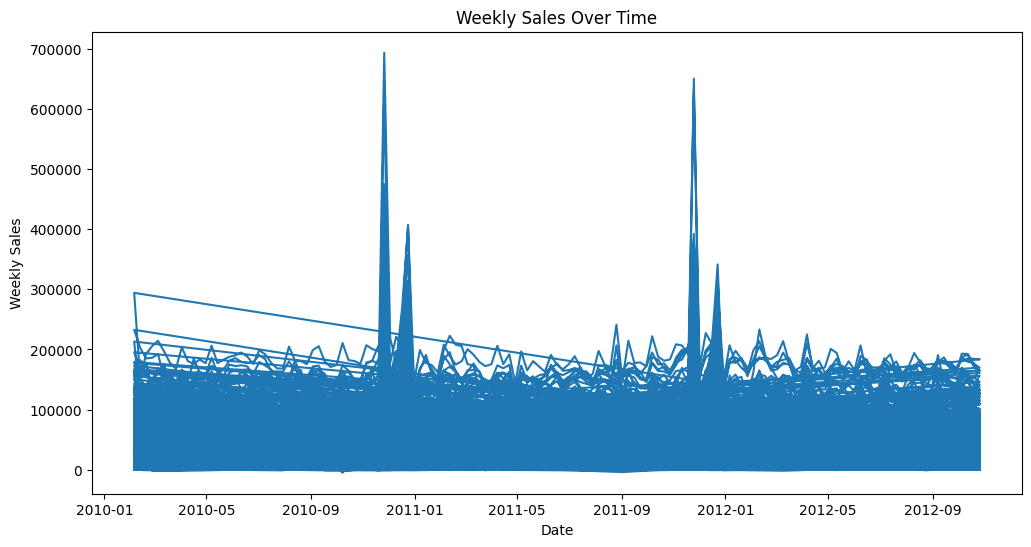

In [29]:
import matplotlib.pyplot as plt

# Plot weekly sales over time to check for seasonal trends and patterns
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Weekly_Sales'])
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()


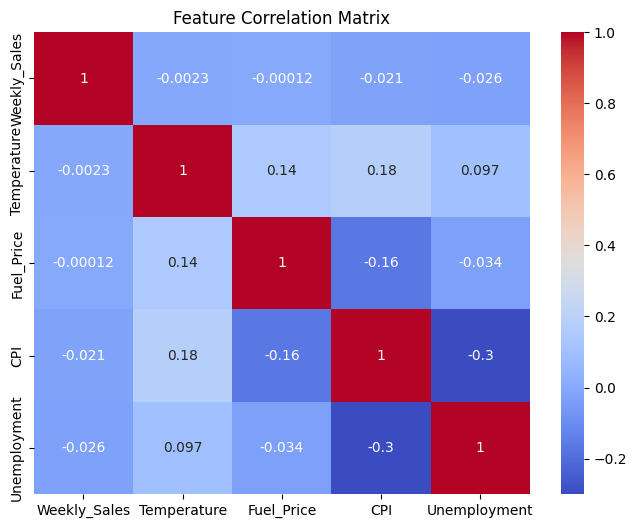

In [30]:
import seaborn as sns

# Calculate correlation matrix for merged train data
corr_matrix = train_merged[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


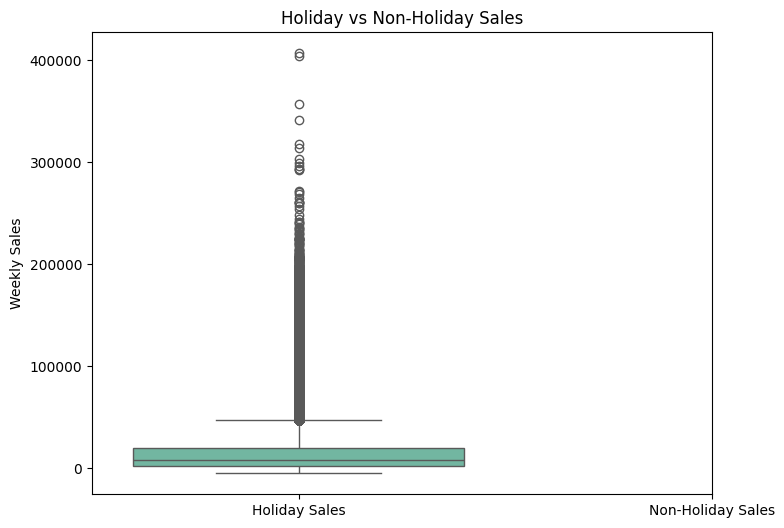

In [31]:
# Check the effect of holidays on sales
holiday_sales = train_df[train_df['IsHoliday'] == True]['Weekly_Sales']
non_holiday_sales = train_df[train_df['IsHoliday'] == False]['Weekly_Sales']

# Plot holiday vs non-holiday sales
plt.figure(figsize=(8, 6))
sns.boxplot(data=[holiday_sales, non_holiday_sales], palette="Set2")
plt.xticks([0, 1], ["Holiday Sales", "Non-Holiday Sales"])
plt.ylabel("Weekly Sales")
plt.title("Holiday vs Non-Holiday Sales")
plt.show()


# Weekly Sales Analysis

### 1. Weekly Sales Over Time
- There are notable peaks and troughs in weekly sales, with significant spikes during holiday periods.
- These peaks indicate important factors such as **seasonality** and **holiday effects** that should be considered in the sales forecasting model.
- Holidays should be factored separately when forecasting sales.

---

### 2. Correlation Matrix
- There is no strong direct correlation observed between **Weekly Sales** and other variables, indicating that other features may not have a direct impact on sales.
- However, economic or weather-related factors like **Fuel Price** and **Temperature** may have indirect effects.
- This suggests that **feature engineering** could capture indirect effects, potentially improving model performance.

---

### 3. Holiday vs. Non-Holiday Sales
- A clear difference in sales between holiday and non-holiday periods is observed.
- High spikes in sales during holidays indicate that the holiday effect is significant and should be considered in the model.
- Including **holiday-related features** in the model could enhance the understanding of holiday impacts on sales.

---

### 4. Missing Data Analysis
- There are several missing values in the **MarkDown** columns.
  - Missing values in these columns could be treated as non-promotional periods and filled with 0.
  - Alternatively, missing values can be filled with **mean/median** values or the MarkDown columns can be excluded from the model if necessary.
- Economic indicators like **CPI (Consumer Price Index)** and **Unemployment** also have some missing data.
  - These missing values can be filled using time-series interpolation methods such as linear interpolation, or these features can be excluded from certain models.

---

### 5. Statistical Summary of Data
- Negative values exist in the **Weekly Sales** column, which may represent returns or cancellations.
  - The meaning of these negative values should be carefully evaluated in the modeling process, and data cleaning or special processing might be necessary.
- The **MarkDown** columns have high standard deviations, reflecting variability in promotional amounts.
  - The impact of this variability should be considered in modeling, and the contribution of these features should be analyzed.

---

### Key Points to Consider in the Model:
1. Create **new features** to capture seasonality and holiday effects.
2. Handle missing values effectively and apply data exclusion strategies where necessary.
3. Add **data cleaning** steps to address negative values and ensure data integrity.


In [32]:
# Convert 'Date' to datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Extract year, month, and day of the week
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['DayOfWeek'] = train_df['Date'].dt.dayofweek


In [33]:
# This is already available in the data as 'IsHoliday'
# Ensure it’s in a binary format (if needed)
train_df['IsHoliday'] = train_df['IsHoliday'].astype(int)


In [34]:
# 4-week, 8-week, and 12-week moving averages for weekly sales
train_df['WeeklySales_MA_4'] = train_df['Weekly_Sales'].rolling(window=4).mean()
train_df['WeeklySales_MA_8'] = train_df['Weekly_Sales'].rolling(window=8).mean()
train_df['WeeklySales_MA_12'] = train_df['Weekly_Sales'].rolling(window=12).mean()


In [35]:
# Lag features: previous 1 and 2 weeks of sales
train_df['WeeklySales_Lag_1'] = train_df['Weekly_Sales'].shift(1)
train_df['WeeklySales_Lag_2'] = train_df['Weekly_Sales'].shift(2)


In [36]:
print(features_df.columns)


Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')


In [37]:
# Fill missing values in MarkDown columns in features_df
features_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = features_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(0)

# Alternatively, fill with median
# features_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = features_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(features_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].median())


In [38]:

features_df['CPI'] = features_df['CPI'].ffill()
features_df['Unemployment'] = features_df['Unemployment'].ffill()


In [39]:
# Check available columns in each DataFrame
print("Columns in train_df:", train_df.columns)
print("Columns in features_df:", features_df.columns)


Columns in train_df: Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month',
       'DayOfWeek', 'WeeklySales_MA_4', 'WeeklySales_MA_8',
       'WeeklySales_MA_12', 'WeeklySales_Lag_1', 'WeeklySales_Lag_2'],
      dtype='object')
Columns in features_df: Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')


In [40]:
# Calculate weekly fuel price change percentage
features_df['FuelPrice_Change'] = features_df['Fuel_Price'].pct_change()


In [41]:
# Lagged CPI and Unemployment features
features_df['CPI_Lag_1'] = features_df['CPI'].shift(1)
features_df['Unemployment_Lag_1'] = features_df['Unemployment'].shift(1)


In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Instantiate separate scalers for each DataFrame
scaler_train = MinMaxScaler()
scaler_features = MinMaxScaler()

# Columns to scale in train_df
train_df_cols_to_scale = ['Weekly_Sales', 'WeeklySales_MA_4', 'WeeklySales_MA_8', 'WeeklySales_MA_12', 'WeeklySales_Lag_1', 'WeeklySales_Lag_2']

# Columns to scale in features_df
features_df_cols_to_scale = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'FuelPrice_Change', 'CPI_Lag_1', 'Unemployment_Lag_1']

# Apply scaling separately to each DataFrame
train_df[train_df_cols_to_scale] = scaler_train.fit_transform(train_df[train_df_cols_to_scale])
features_df[features_df_cols_to_scale] = scaler_features.fit_transform(features_df[features_df_cols_to_scale])



In [43]:
# Check for missing values in train_df and features_df
print("Missing values in train_df:")
print(train_df.isnull().sum())
print("\nMissing values in features_df:")
print(features_df.isnull().sum())


Missing values in train_df:
Store                 0
Dept                  0
Date                  0
Weekly_Sales          0
IsHoliday             0
Year                  0
Month                 0
DayOfWeek             0
WeeklySales_MA_4      3
WeeklySales_MA_8      7
WeeklySales_MA_12    11
WeeklySales_Lag_1     1
WeeklySales_Lag_2     2
dtype: int64

Missing values in features_df:
Store                 0
Date                  0
Temperature           0
Fuel_Price            0
MarkDown1             0
MarkDown2             0
MarkDown3             0
MarkDown4             0
MarkDown5             0
CPI                   0
Unemployment          0
IsHoliday             0
FuelPrice_Change      1
CPI_Lag_1             1
Unemployment_Lag_1    1
dtype: int64


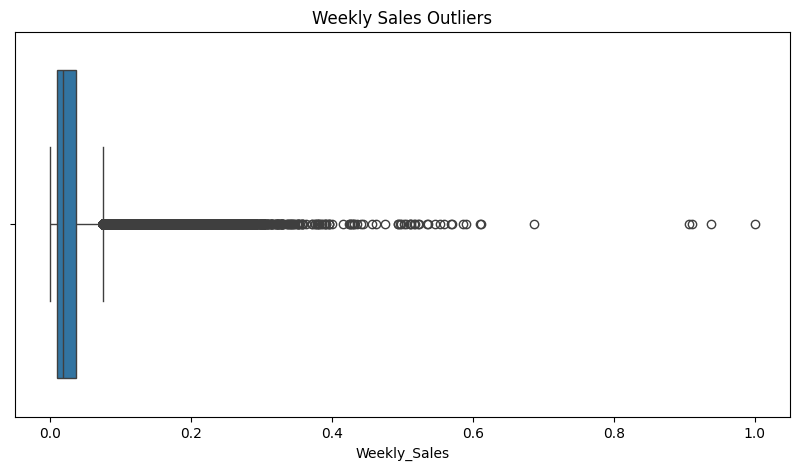

In [44]:
# Check for outliers in key columns in features_df and train_df
import matplotlib.pyplot as plt
import seaborn as sns

# Example for boxplot for 'Weekly_Sales' in train_df
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x='Weekly_Sales')
plt.title('Weekly Sales Outliers')
plt.show()

# Repeat similar plots for Temperature, Fuel_Price, CPI, Unemployment in features_df


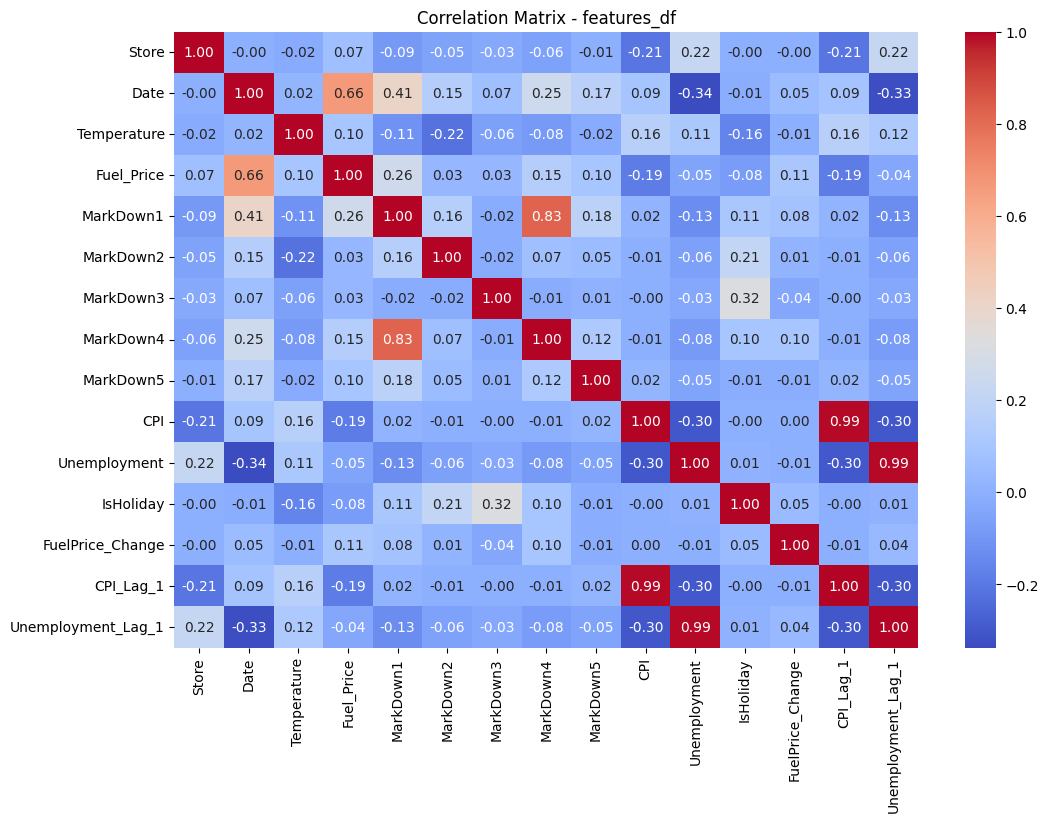

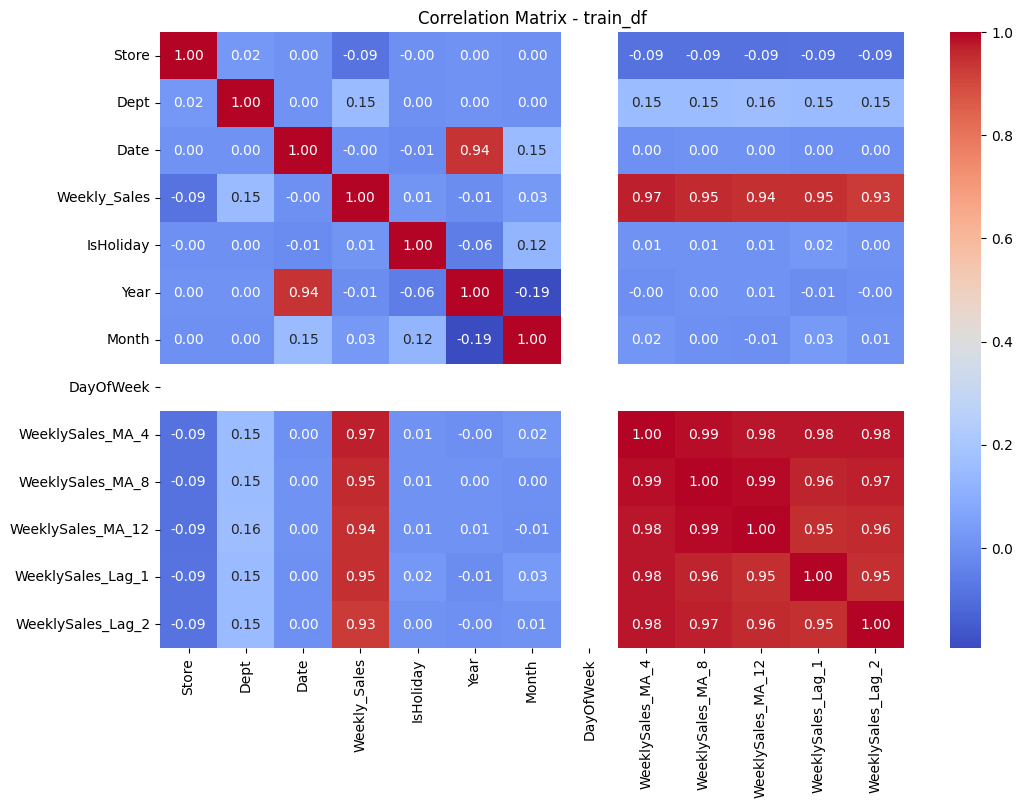

In [45]:
# Correlation matrix for features_df
plt.figure(figsize=(12, 8))
sns.heatmap(features_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - features_df')
plt.show()

# Correlation matrix for train_df (if applicable)
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - train_df')
plt.show()


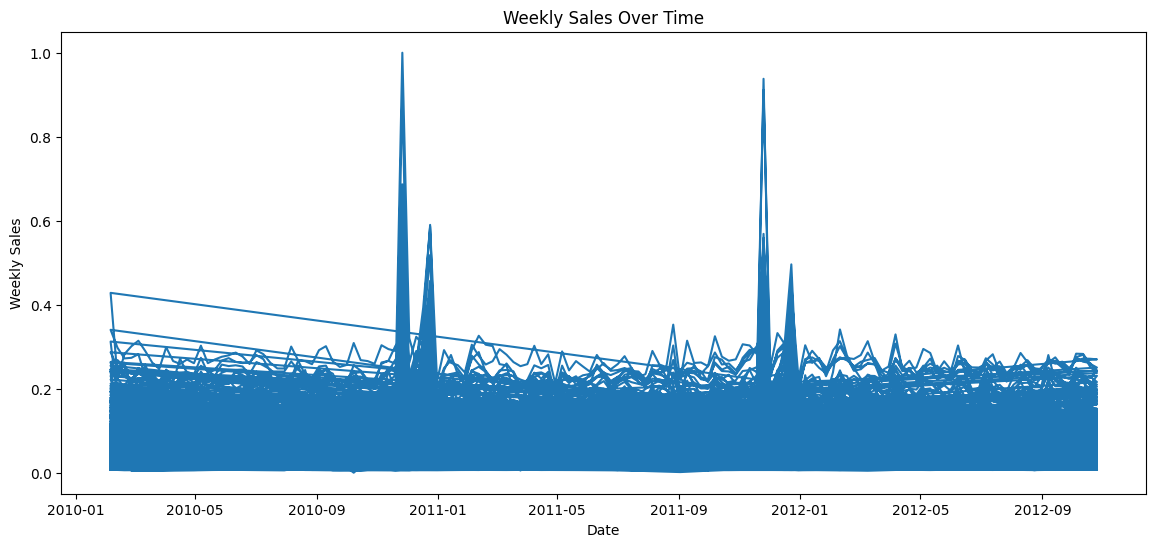

In [46]:
# Plot Weekly Sales over time to observe trend and seasonality
plt.figure(figsize=(14, 6))
plt.plot(train_df['Date'], train_df['Weekly_Sales'])
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


In [47]:
# Fill missing values in moving averages and lag features in train_df
train_df['WeeklySales_MA_4'] = train_df['WeeklySales_MA_4'].bfill()
train_df['WeeklySales_MA_8'] = train_df['WeeklySales_MA_8'].bfill()
train_df['WeeklySales_MA_12'] = train_df['WeeklySales_MA_12'].bfill()
train_df['WeeklySales_Lag_1'] = train_df['WeeklySales_Lag_1'].bfill()
train_df['WeeklySales_Lag_2'] = train_df['WeeklySales_Lag_2'].bfill()

# Fill missing values in lagged economic indicators in features_df
features_df['FuelPrice_Change'] = features_df['FuelPrice_Change'].bfill()
features_df['CPI_Lag_1'] = features_df['CPI_Lag_1'].bfill()
features_df['Unemployment_Lag_1'] = features_df['Unemployment_Lag_1'].bfill()


In [48]:
# Fill missing values in lagged economic indicators in features_df
features_df['FuelPrice_Change'] = features_df['FuelPrice_Change'].bfill()
features_df['CPI_Lag_1'] = features_df['CPI_Lag_1'].bfill()
features_df['Unemployment_Lag_1'] = features_df['Unemployment_Lag_1'].bfill()


In [49]:
# Compare Weekly Sales for holiday vs non-holiday periods
holiday_sales = train_df[train_df['IsHoliday'] == True]['Weekly_Sales']
non_holiday_sales = train_df[train_df['IsHoliday'] == False]['Weekly_Sales']

print("Average Weekly Sales on Holidays:", holiday_sales.mean())
print("Average Weekly Sales on Non-Holidays:", non_holiday_sales.mean())


Average Weekly Sales on Holidays: 0.031550110762994306
Average Weekly Sales on Non-Holidays: 0.02992513277906014


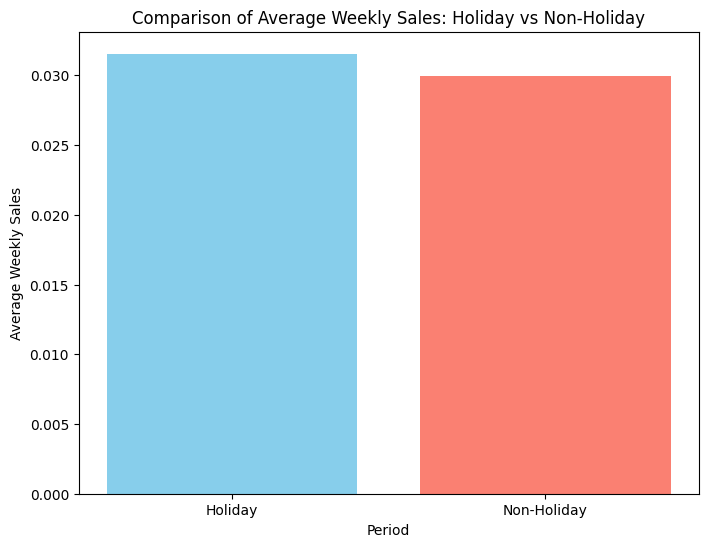

In [50]:
import matplotlib.pyplot as plt

# Calculate average sales for holidays and non-holidays
average_sales = {
    'Holiday': holiday_sales.mean(),
    'Non-Holiday': non_holiday_sales.mean()
}

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(average_sales.keys(), average_sales.values(), color=['skyblue', 'salmon'])
plt.xlabel("Period")
plt.ylabel("Average Weekly Sales")
plt.title("Comparison of Average Weekly Sales: Holiday vs Non-Holiday")
plt.show()


In [51]:
# Capping outliers in Weekly Sales
Q1 = train_df['Weekly_Sales'].quantile(0.25)
Q3 = train_df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_df['Weekly_Sales'] = train_df['Weekly_Sales'].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))


In [52]:
# Drop highly correlated features if necessary
train_df.drop(['WeeklySales_MA_8', 'WeeklySales_MA_12'], axis=1, inplace=True)


In [53]:
# Extracting Year, Month, DayOfWeek features
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['DayOfWeek'] = train_df['Date'].dt.dayofweek


In [54]:
# Fill missing values in lagged economic indicators
features_df['FuelPrice_Change'] = features_df['FuelPrice_Change'].fillna(method='bfill')
features_df['CPI_Lag_1'] = features_df['CPI_Lag_1'].fillna(method='bfill')
features_df['Unemployment_Lag_1'] = features_df['Unemployment_Lag_1'].fillna(method='bfill')

# Fill missing values in lagged Weekly Sales moving averages
train_df['WeeklySales_MA_4'] = train_df['WeeklySales_MA_4'].fillna(method='bfill')
train_df['WeeklySales_Lag_1'] = train_df['WeeklySales_Lag_1'].fillna(method='bfill')
train_df['WeeklySales_Lag_2'] = train_df['WeeklySales_Lag_2'].fillna(method='bfill')



<ipython-input-54-c40fde665a22>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df['FuelPrice_Change'] = features_df['FuelPrice_Change'].fillna(method='bfill')
<ipython-input-54-c40fde665a22>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df['CPI_Lag_1'] = features_df['CPI_Lag_1'].fillna(method='bfill')
<ipython-input-54-c40fde665a22>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df['Unemployment_Lag_1'] = features_df['Unemployment_Lag_1'].fillna(method='bfill')
<ipython-input-54-c40fde665a22>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df['WeeklySales_MA_4'] = train_df['WeeklySales_MA_4'].fil

In [55]:
print("Columns in train_df:", train_df.columns)
print("Columns in features_df:", features_df.columns)



Columns in train_df: Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month',
       'DayOfWeek', 'WeeklySales_MA_4', 'WeeklySales_Lag_1',
       'WeeklySales_Lag_2'],
      dtype='object')
Columns in features_df: Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'FuelPrice_Change', 'CPI_Lag_1', 'Unemployment_Lag_1'],
      dtype='object')


In [56]:
from sklearn.preprocessing import MinMaxScaler

# Train dataframe için scaler ve kolonları ölçekleme
train_scaler = MinMaxScaler()
train_df_cols_to_scale = ['Weekly_Sales', 'WeeklySales_MA_4', 'WeeklySales_Lag_1', 'WeeklySales_Lag_2']
train_df[train_df_cols_to_scale] = train_scaler.fit_transform(train_df[train_df_cols_to_scale])

# Features dataframe için scaler ve kolonları ölçekleme
features_scaler = MinMaxScaler()
features_df_cols_to_scale = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'FuelPrice_Change', 'CPI_Lag_1', 'Unemployment_Lag_1']
features_df[features_df_cols_to_scale] = features_scaler.fit_transform(features_df[features_df_cols_to_scale])



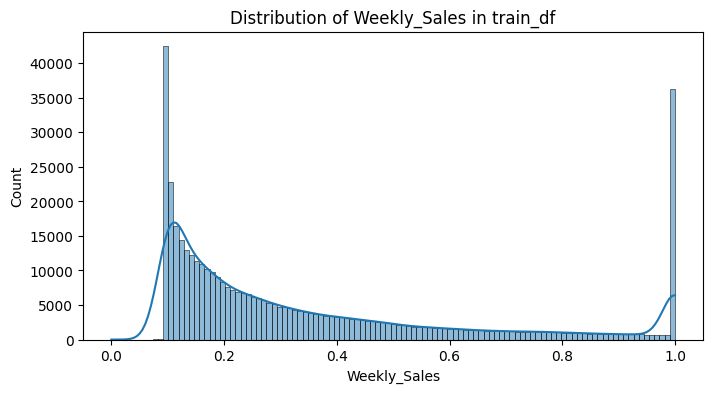

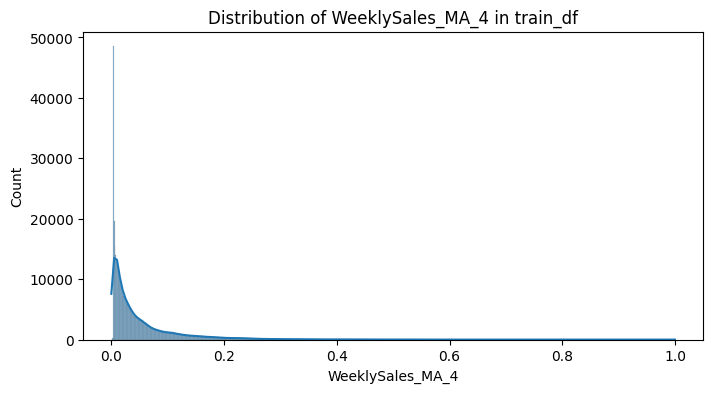

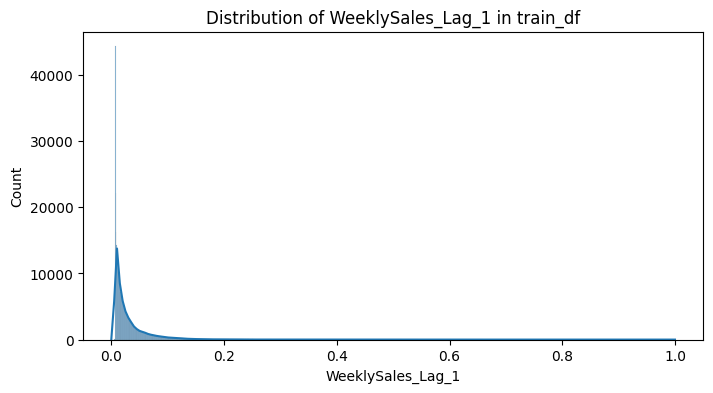

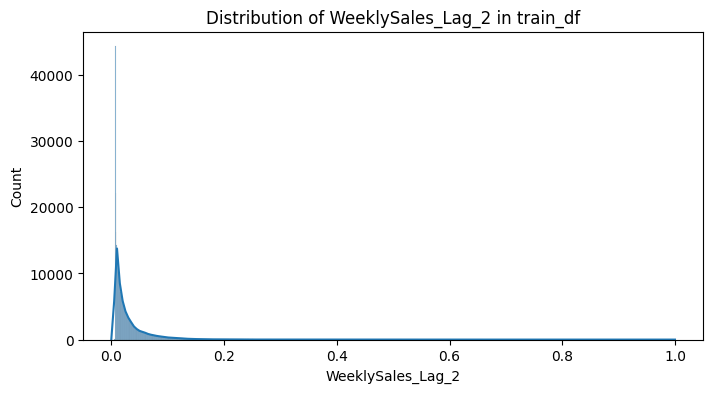

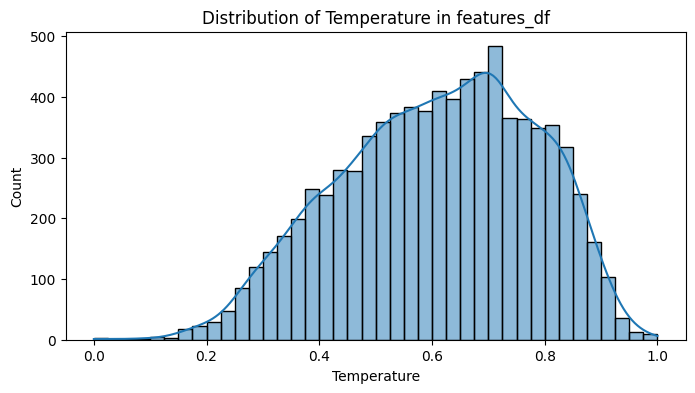

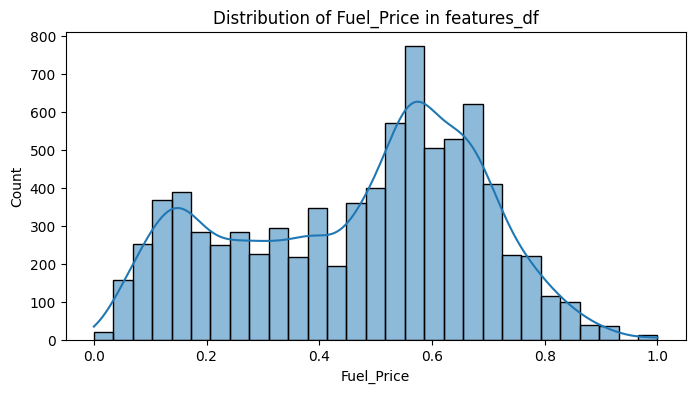

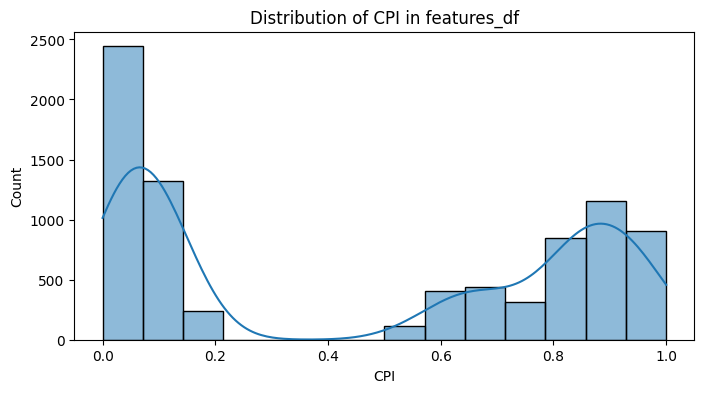

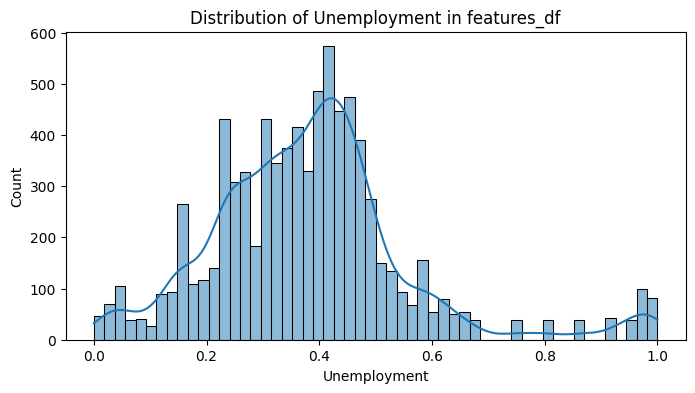

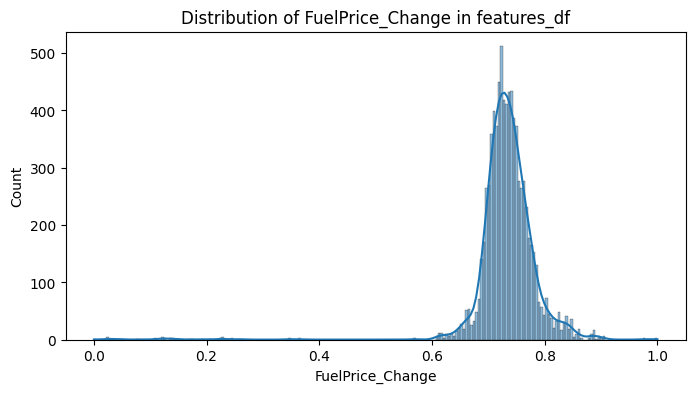

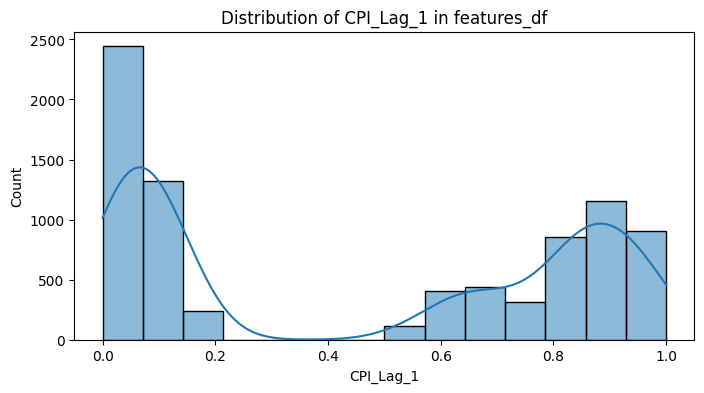

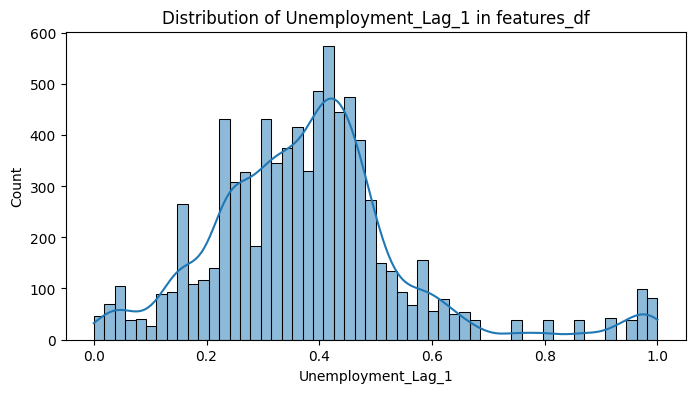

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

train_continuous_vars = ['Weekly_Sales', 'WeeklySales_MA_4', 'WeeklySales_Lag_1', 'WeeklySales_Lag_2']
for var in train_continuous_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[var], kde=True)
    plt.title(f"Distribution of {var} in train_df")
    plt.show()

features_continuous_vars = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'FuelPrice_Change', 'CPI_Lag_1', 'Unemployment_Lag_1']
for var in features_continuous_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(features_df[var], kde=True)
    plt.title(f"Distribution of {var} in features_df")
    plt.show()


In [58]:
# Veri setindeki sütun isimlerini kontrol edelim
print("train_df columns:", train_df.columns)
print("features_df columns:", features_df.columns)


train_df columns: Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month',
       'DayOfWeek', 'WeeklySales_MA_4', 'WeeklySales_Lag_1',
       'WeeklySales_Lag_2'],
      dtype='object')
features_df columns: Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'FuelPrice_Change', 'CPI_Lag_1', 'Unemployment_Lag_1'],
      dtype='object')


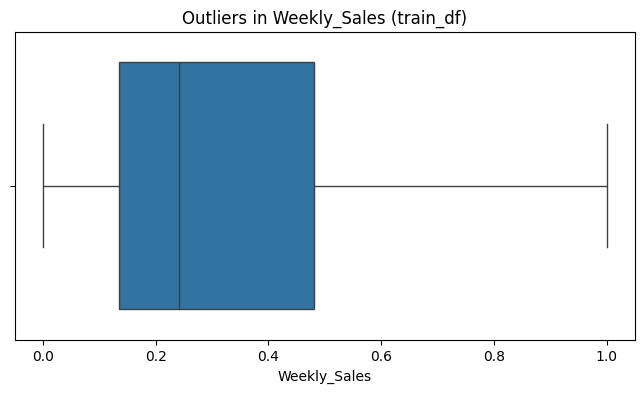

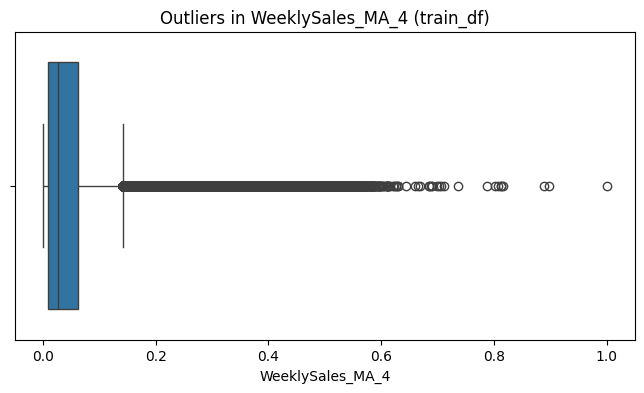

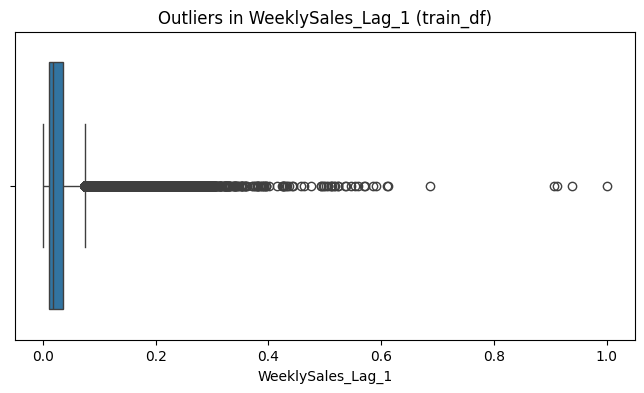

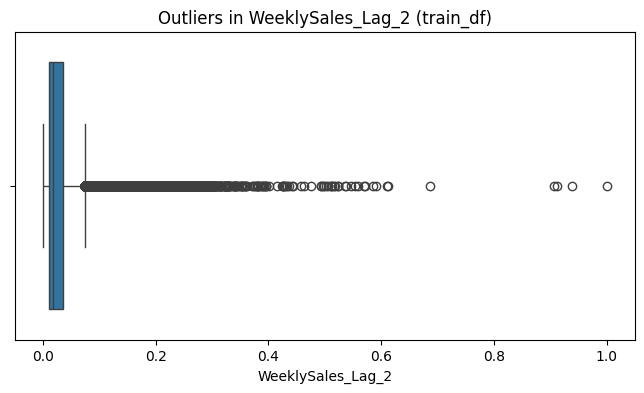

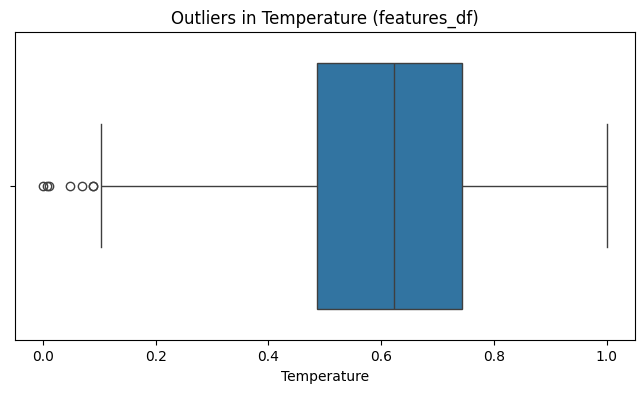

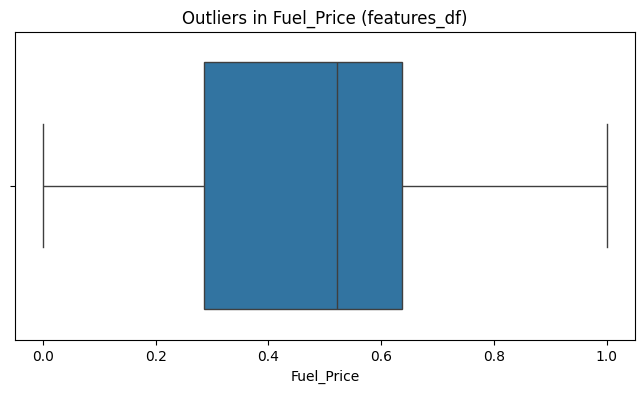

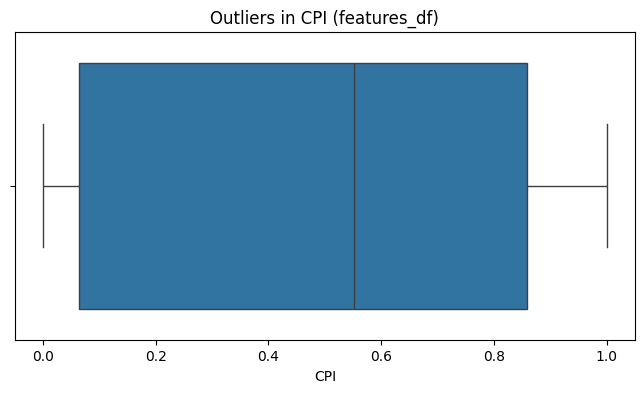

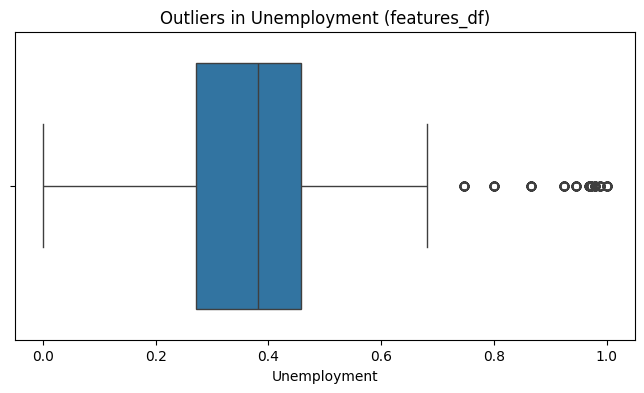

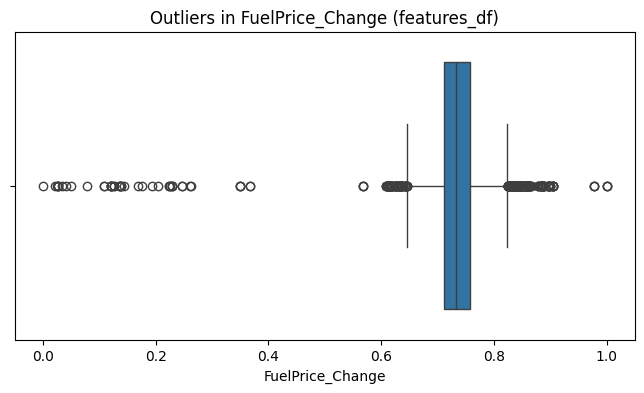

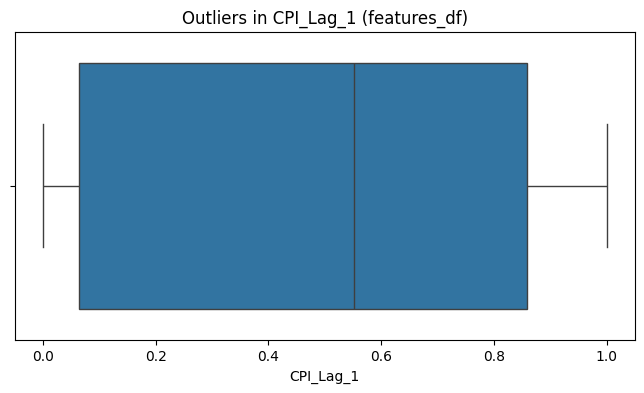

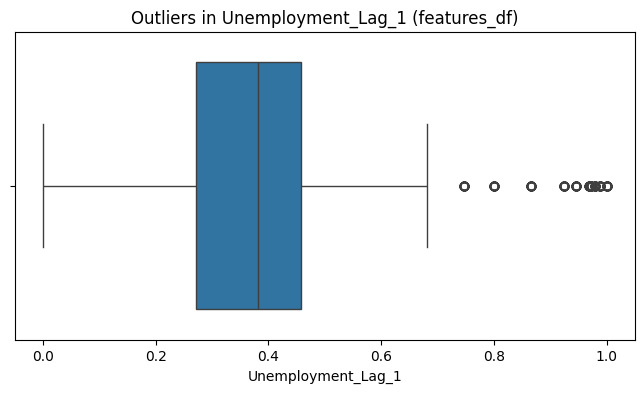

In [59]:
# Outlier analizi için değişken listeleri
train_continuous_vars = ['Weekly_Sales', 'WeeklySales_MA_4', 'WeeklySales_Lag_1', 'WeeklySales_Lag_2']
features_continuous_vars = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'FuelPrice_Change', 'CPI_Lag_1', 'Unemployment_Lag_1']

# train_df için outlier analizi
for var in train_continuous_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_df[var])
    plt.title(f"Outliers in {var} (train_df)")
    plt.show()

# features_df için outlier analizi
for var in features_continuous_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=features_df[var])
    plt.title(f"Outliers in {var} (features_df)")
    plt.show()


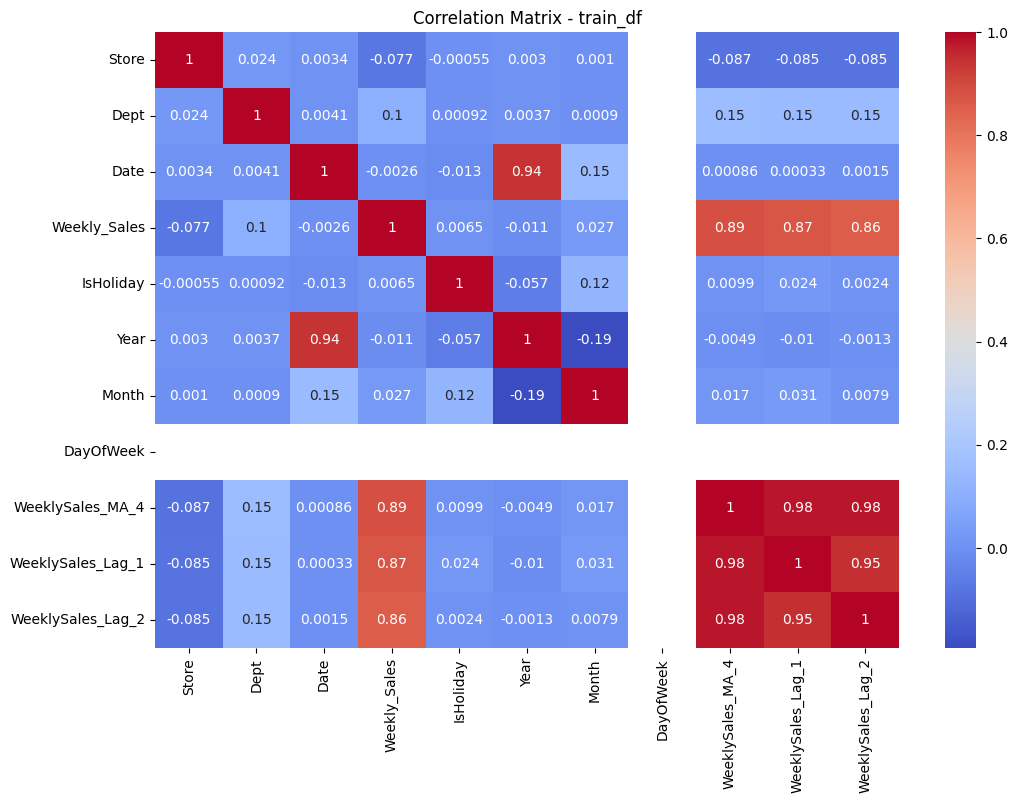

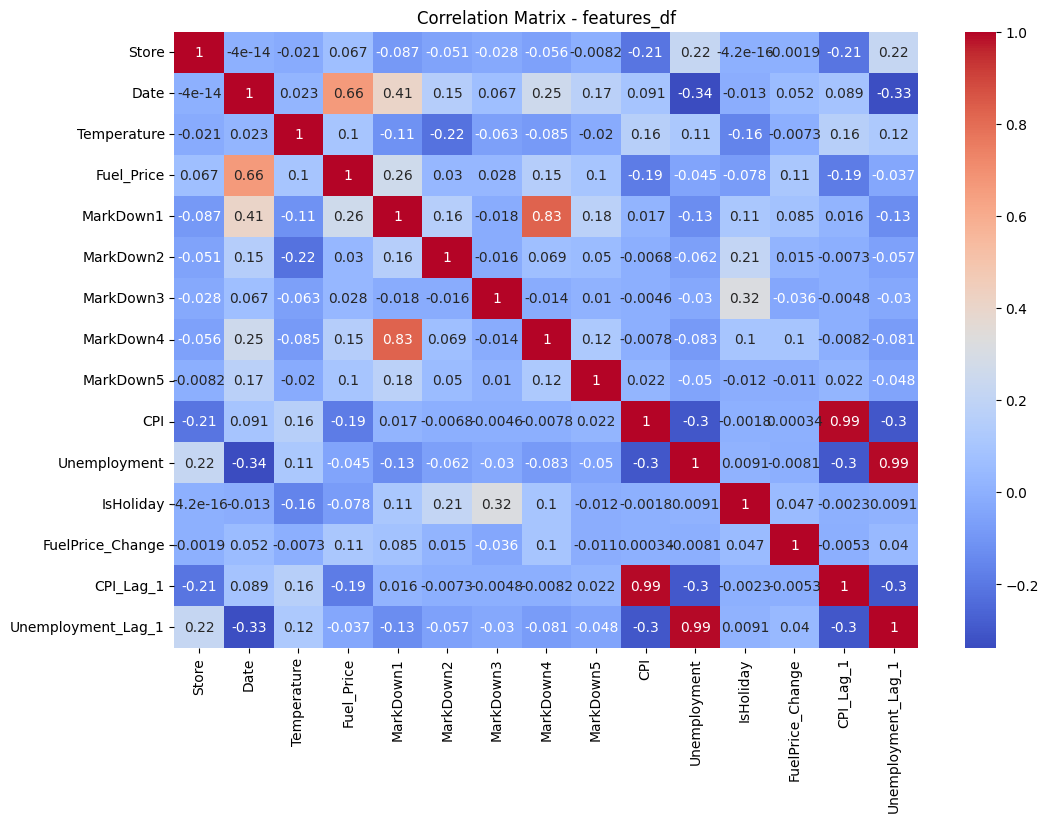

In [60]:
# train_df için korelasyon matrisi
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - train_df')
plt.show()

# features_df için korelasyon matrisi
plt.figure(figsize=(12, 8))
sns.heatmap(features_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - features_df')
plt.show()


In [61]:
print("Missing values in train_df:\n", train_df.isnull().sum())
print("Missing values in features_df:\n", features_df.isnull().sum())


Missing values in train_df:
 Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Year                 0
Month                0
DayOfWeek            0
WeeklySales_MA_4     0
WeeklySales_Lag_1    0
WeeklySales_Lag_2    0
dtype: int64
Missing values in features_df:
 Store                 0
Date                  0
Temperature           0
Fuel_Price            0
MarkDown1             0
MarkDown2             0
MarkDown3             0
MarkDown4             0
MarkDown5             0
CPI                   0
Unemployment          0
IsHoliday             0
FuelPrice_Change      0
CPI_Lag_1             0
Unemployment_Lag_1    0
dtype: int64


Average Weekly Sales on Holidays: 0.36253766045300656
Average Weekly Sales on Non-Holidays: 0.3552917871119003


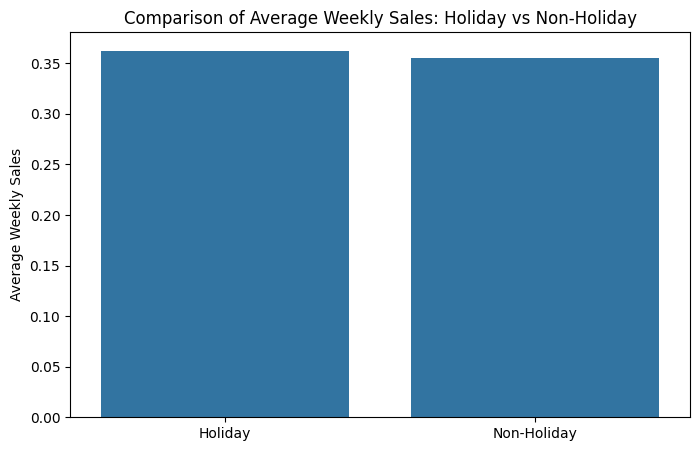

In [62]:
# Tatil günlerine göre Weekly_Sales analizi
if 'Weekly_Sales' in train_df.columns:
    holiday_sales = train_df[train_df['IsHoliday'] == True]['Weekly_Sales']
    non_holiday_sales = train_df[train_df['IsHoliday'] == False]['Weekly_Sales']

    print("Average Weekly Sales on Holidays:", holiday_sales.mean())
    print("Average Weekly Sales on Non-Holidays:", non_holiday_sales.mean())

    # Görselleştirme
    plt.figure(figsize=(8, 5))
    sns.barplot(x=['Holiday', 'Non-Holiday'], y=[holiday_sales.mean(), non_holiday_sales.mean()])
    plt.ylabel("Average Weekly Sales")
    plt.title("Comparison of Average Weekly Sales: Holiday vs Non-Holiday")
    plt.show()
else:
    print("'Weekly_Sales' sütunu train_df'de bulunamadı.")


In [63]:
# Özet istatistikler
print("Summary statistics for train_df:\n", train_df.describe())
print("Summary statistics for features_df:\n", features_df.describe())

Summary statistics for train_df:
                Store           Dept                           Date  \
count  421570.000000  421570.000000                         421570   
mean       22.200546      44.260317  2011-06-18 08:30:31.963375104   
min         1.000000       1.000000            2010-02-05 00:00:00   
25%        11.000000      18.000000            2010-10-08 00:00:00   
50%        22.000000      37.000000            2011-06-17 00:00:00   
75%        33.000000      74.000000            2012-02-24 00:00:00   
max        45.000000      99.000000            2012-10-26 00:00:00   
std        12.785297      30.492054                            NaN   

        Weekly_Sales      IsHoliday           Year          Month  DayOfWeek  \
count  421570.000000  421570.000000  421570.000000  421570.000000   421570.0   
mean        0.355802       0.070358    2010.968591       6.449510        4.0   
min         0.000000       0.000000    2010.000000       1.000000        4.0   
25%         0.1

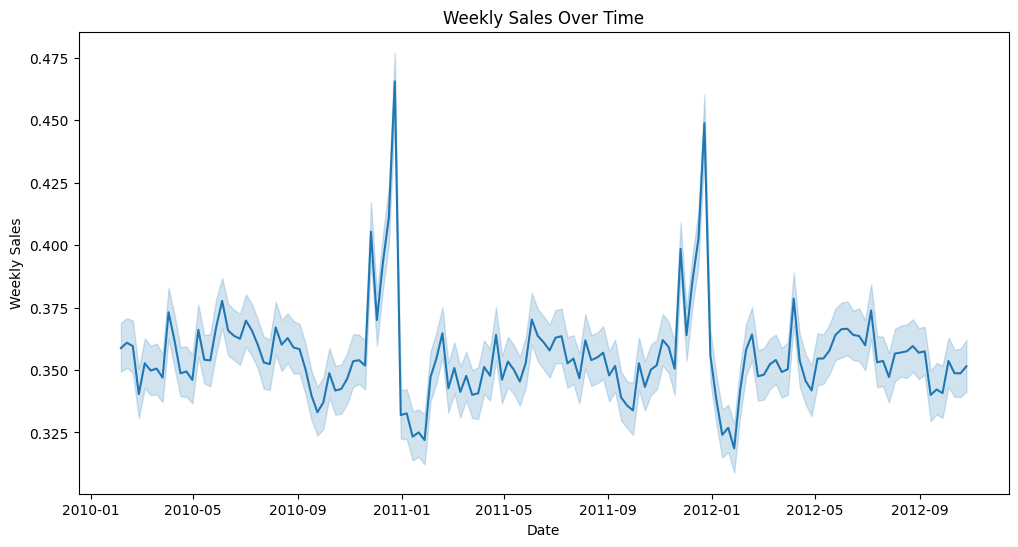

In [64]:
# Weekly Sales trend analizi
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_df['Date'], y=train_df['Weekly_Sales'])
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()


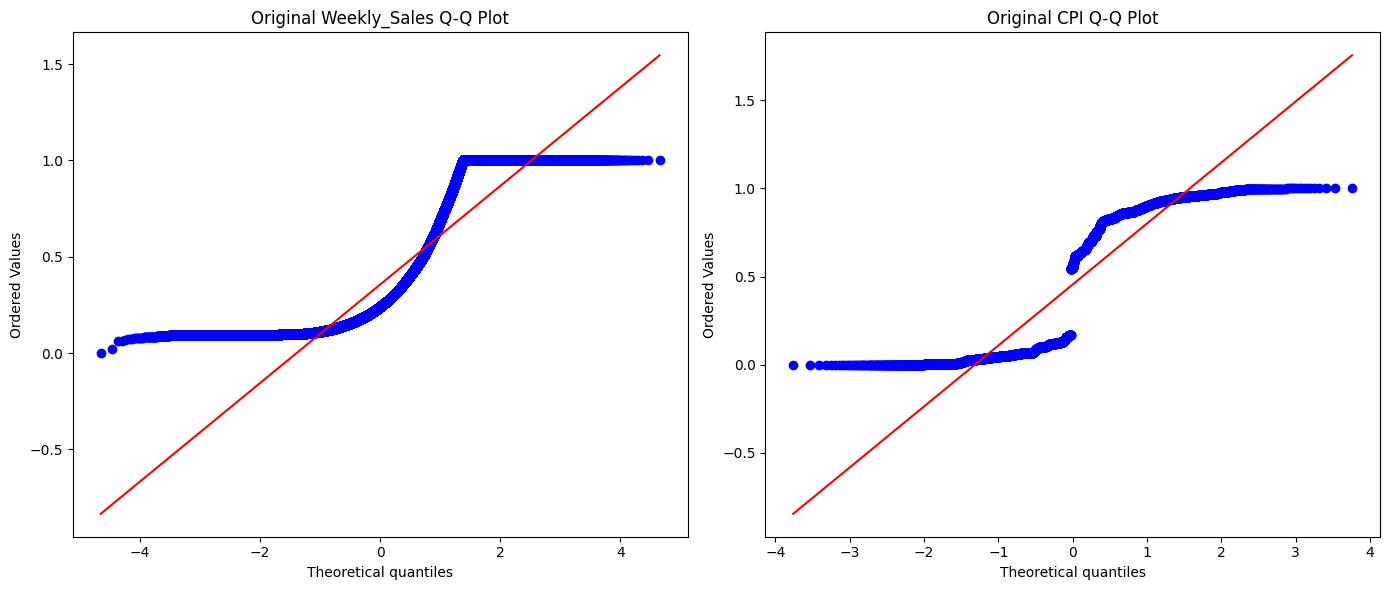

In [65]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Weekly_Sales ve CPI için Q-Q plotları
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Weekly_Sales Q-Q plot
stats.probplot(train_df['Weekly_Sales'], dist="norm", plot=axes[0])
axes[0].set_title("Original Weekly_Sales Q-Q Plot")

# CPI Q-Q plot
stats.probplot(features_df['CPI'].dropna(), dist="norm", plot=axes[1])
axes[1].set_title("Original CPI Q-Q Plot")

plt.tight_layout()
plt.show()



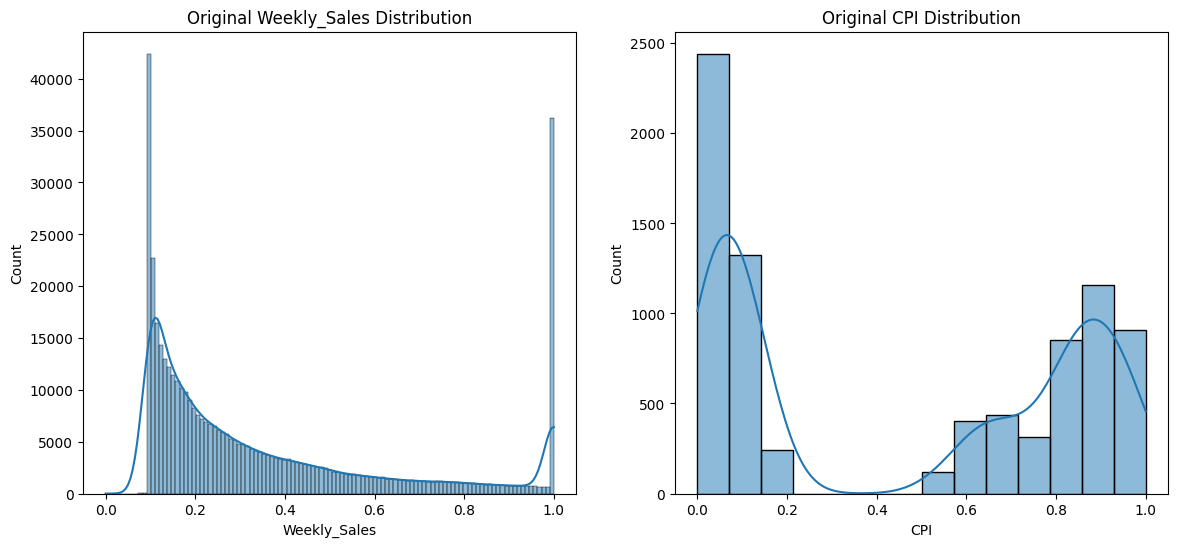

Orijinal Weekly_Sales İstatistikleri:
 count    421570.000000
mean          0.355802
std           0.284605
min           0.000000
25%           0.134938
50%           0.240550
75%           0.480963
max           1.000000
Name: Weekly_Sales, dtype: float64
Orijinal CPI İstatistikleri:
 count    8190.000000
mean        0.454676
std         0.387692
min         0.000000
25%         0.064033
50%         0.551846
75%         0.858045
max         1.000000
Name: CPI, dtype: float64


In [66]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(train_df['Weekly_Sales'], kde=True, ax=axes[0])
axes[0].set_title("Original Weekly_Sales Distribution")

sns.histplot(features_df['CPI'].dropna(), kde=True, ax=axes[1])
axes[1].set_title("Original CPI Distribution")

plt.show()


print("Orijinal Weekly_Sales İstatistikleri:\n", train_df['Weekly_Sales'].describe())
print("Orijinal CPI İstatistikleri:\n", features_df['CPI'].describe())


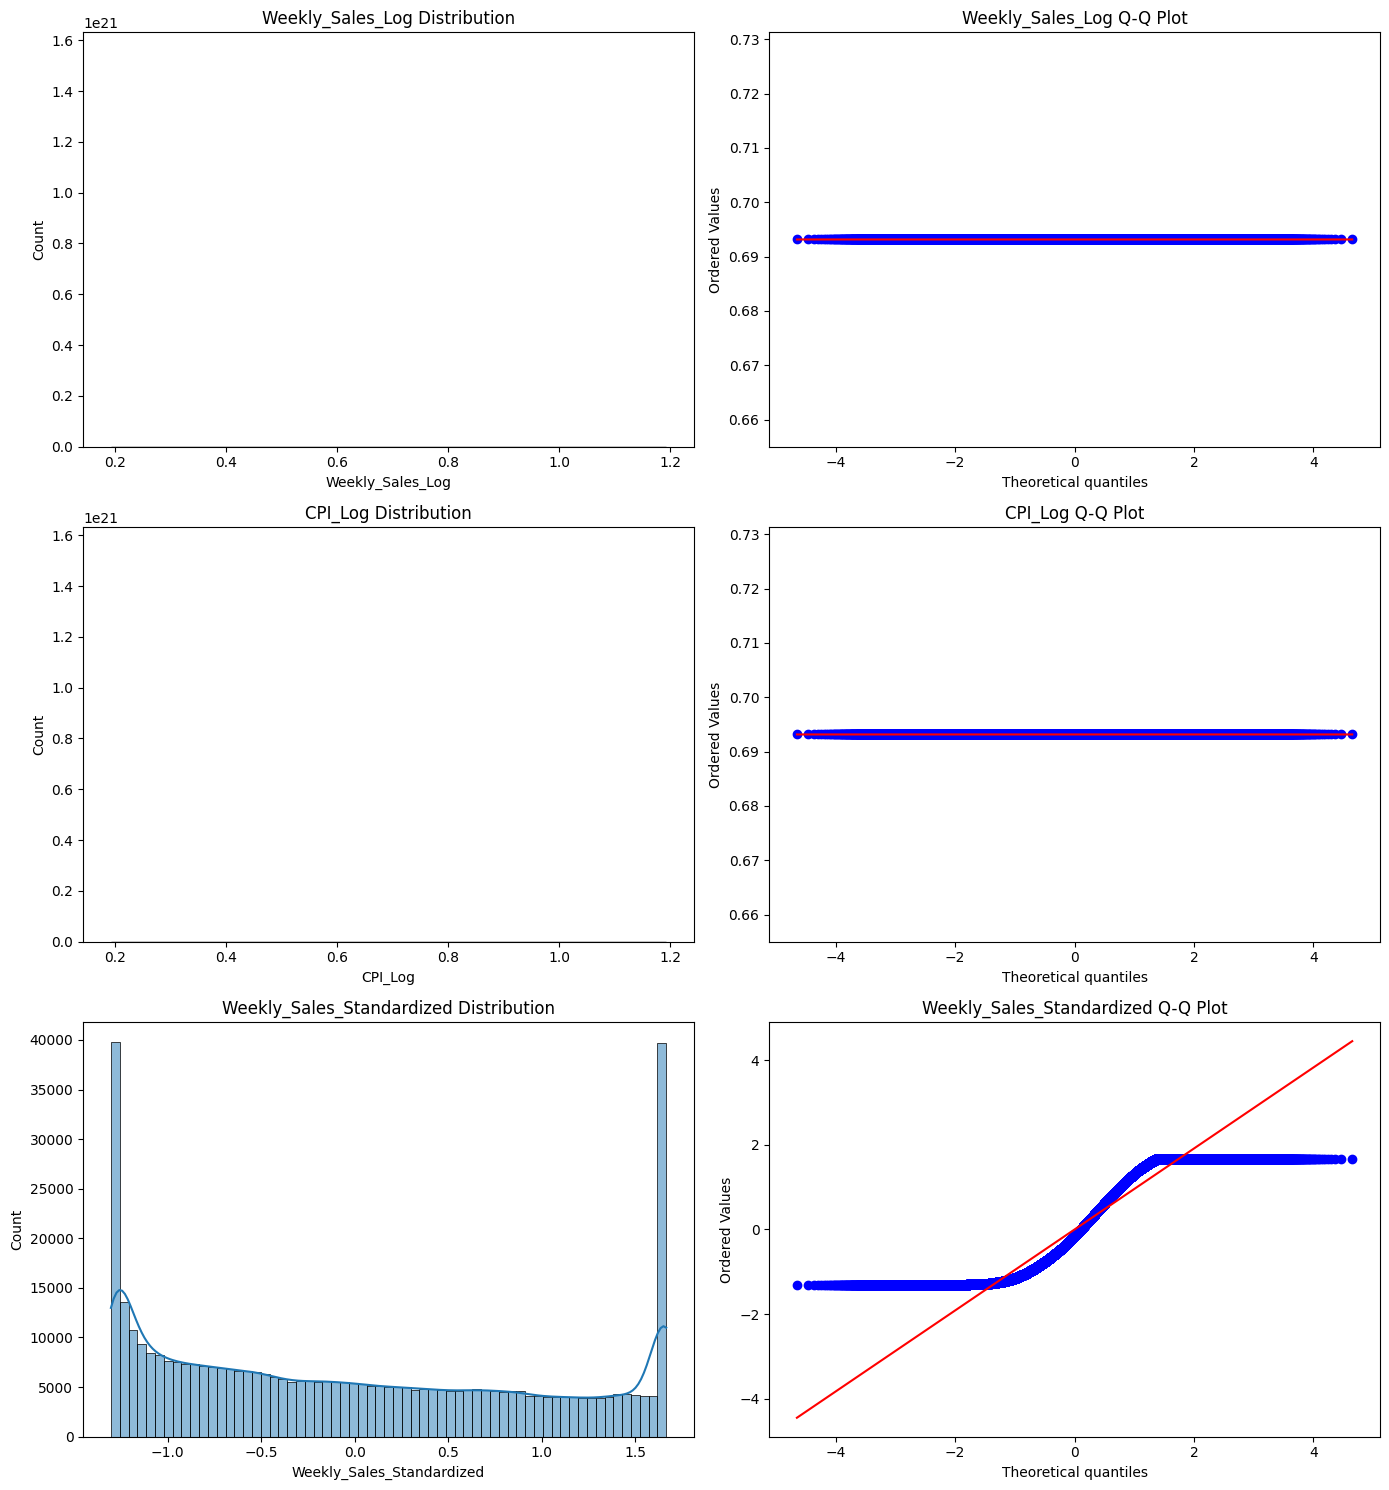

Fitted lambda for Weekly_Sales Yeo-Johnson: -3.277932257774962
Fitted lambda for CPI Yeo-Johnson: -0.11374884003553046


In [67]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox, yeojohnson, zscore
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 1. Merging Datasets
combined_df = pd.merge(train_df, features_df, on=['Store', 'Date'], how="left")
combined_df.fillna(0, inplace=True)

# 2. More Aggressive Winsorization (Limit to 2% to handle outliers)
combined_df['Weekly_Sales_Winsorized'] = winsorize(combined_df['Weekly_Sales'], limits=[0.02, 0.02])
combined_df['CPI_Winsorized'] = winsorize(combined_df['CPI'], limits=[0.02, 0.02])

# 3. Log Transformation with Winsorized Data
combined_df['Weekly_Sales_Log'] = np.log1p(combined_df['Weekly_Sales_Winsorized'].clip(lower=1))
combined_df['CPI_Log'] = np.log1p(combined_df['CPI_Winsorized'].clip(lower=1))

# 4. Yeo-Johnson Transformation as alternative to Box-Cox
combined_df['Weekly_Sales_YeoJohnson'], fitted_lambda_sales_yj = yeojohnson(combined_df['Weekly_Sales_Winsorized'])
combined_df['CPI_YeoJohnson'], fitted_lambda_cpi_yj = yeojohnson(combined_df['CPI_Winsorized'])

# 5. Standardization of Transformed Data
# Z-score standardization to make data centered at 0 with a standard deviation of 1
combined_df['Weekly_Sales_Standardized'] = zscore(combined_df['Weekly_Sales_YeoJohnson'])
combined_df['CPI_Standardized'] = zscore(combined_df['CPI_YeoJohnson'])

# 6. Plotting Distributions and Q-Q Plots
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Weekly_Sales_Log distribution and Q-Q plot
sns.histplot(combined_df['Weekly_Sales_Log'], kde=True, ax=axes[0, 0]).set_title("Weekly_Sales_Log Distribution")
stats.probplot(combined_df['Weekly_Sales_Log'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Weekly_Sales_Log Q-Q Plot")

# CPI_Log distribution and Q-Q plot
sns.histplot(combined_df['CPI_Log'], kde=True, ax=axes[1, 0]).set_title("CPI_Log Distribution")
stats.probplot(combined_df['CPI_Log'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("CPI_Log Q-Q Plot")

# Standardized Weekly_Sales_YeoJohnson distribution and Q-Q plot
sns.histplot(combined_df['Weekly_Sales_Standardized'], kde=True, ax=axes[2, 0]).set_title("Weekly_Sales_Standardized Distribution")
stats.probplot(combined_df['Weekly_Sales_Standardized'], dist="norm", plot=axes[2, 1])
axes[2, 1].set_title("Weekly_Sales_Standardized Q-Q Plot")

plt.tight_layout()
plt.show()

# Print fitted lambda values for reference
print(f"Fitted lambda for Weekly_Sales Yeo-Johnson: {fitted_lambda_sales_yj}")
print(f"Fitted lambda for CPI Yeo-Johnson: {fitted_lambda_cpi_yj}")


In [68]:
# Tüm sayısal özellikleri seçin (Weekly_Sales ve CPI dışındaki özellikler de dahil)
numeric_features = combined_df.select_dtypes(include=[np.number]).columns

# Her bir özellik üzerinde dönüşüm ve normalizasyon işlemlerini uygulayın
for feature in numeric_features:
    # Aşırı uçları sınırlamak için Winsorization (2% sınırı)
    combined_df[f'{feature}_Winsorized'] = winsorize(combined_df[feature], limits=[0.02, 0.02])

    # Log veya Yeo-Johnson dönüşümüne uygunluk kontrolü
    if (combined_df[f'{feature}_Winsorized'] > 0).all():  # tüm değerler pozitifse
        combined_df[f'{feature}_Log'] = np.log1p(combined_df[f'{feature}_Winsorized'])
        combined_df[f'{feature}_YeoJohnson'], lambda_ = yeojohnson(combined_df[f'{feature}_Winsorized'])
    else:
        # Negatif değer varsa sadece Yeo-Johnson uygulanabilir
        combined_df[f'{feature}_YeoJohnson'], lambda_ = yeojohnson(combined_df[f'{feature}_Winsorized'])

    # Özellikleri standartlaştırma
    combined_df[f'{feature}_Standardized'] = zscore(combined_df[f'{feature}_YeoJohnson'])

# Güncellenmiş veri setini ve özellik isimlerini görüntüleyin
print("Normalized features:\n", combined_df.filter(regex='_Standardized').head())


<ipython-input-68-5a51b8b28e98>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'{feature}_Winsorized'] = winsorize(combined_df[feature], limits=[0.02, 0.02])
<ipython-input-68-5a51b8b28e98>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'{feature}_Log'] = np.log1p(combined_df[f'{feature}_Winsorized'])
<ipython-input-68-5a51b8b28e98>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

Normalized features:
    Weekly_Sales_Standardized  CPI_Standardized  Store_Standardized  \
0                   1.088043          1.020313           -1.950537   
1                   1.645842          1.023108           -1.950537   
2                   1.568309          1.024007           -1.950537   
3                   0.817483          1.024591           -1.950537   
4                   0.946247          1.025175           -1.950537   

   Dept_Standardized  IsHoliday_x_Standardized  Year_Standardized  \
0          -1.913804                 -0.275106          -1.215824   
1          -1.913804                  3.634961          -1.215824   
2          -1.913804                 -0.275106          -1.215824   
3          -1.913804                 -0.275106          -1.215824   
4          -1.913804                 -0.275106          -1.215824   

   Month_Standardized  DayOfWeek_Standardized  WeeklySales_MA_4_Standardized  \
0           -1.428794                     NaN                 

In [69]:
# Modelleme için seçilen özelliklerin örneği
model_features = combined_df[[
    'Weekly_Sales_Log_Standardized',
    'CPI_Log_Standardized',
    'Store_Standardized',
    'Dept_Standardized',
    'Temperature_Standardized',
    'Fuel_Price_Standardized',
    'MarkDown1_Standardized',
    'MarkDown2_Standardized',
    'MarkDown3_Standardized',
    'MarkDown4_Standardized',
    'MarkDown5_Standardized'
]]

# Modelleme sürecine başlamak için model_features'ı kullanabilirsiniz.
print(model_features.head())


   Weekly_Sales_Log_Standardized  CPI_Log_Standardized  Store_Standardized  \
0                       1.081414              1.017271           -1.950537   
1                       1.618244              1.019674           -1.950537   
2                       1.541255              1.020448           -1.950537   
3                       0.825279              1.020950           -1.950537   
4                       0.947307              1.021452           -1.950537   

   Dept_Standardized  Temperature_Standardized  Fuel_Price_Standardized  \
0          -1.913804                 -0.999947                -1.667117   
1          -1.913804                 -1.183263                -1.667117   
2          -1.913804                 -1.115413                -1.667117   
3          -1.913804                 -0.784757                -1.667117   
4          -1.913804                 -0.791338                -1.587410   

   MarkDown1_Standardized  MarkDown2_Standardized  MarkDown3_Standardized  \
0  

In [70]:

missing_data = model_features.isnull().sum()
print("Eksik veri kontrolü:\n", missing_data[missing_data > 0])


Eksik veri kontrolü:
 Series([], dtype: int64)


In [71]:

from scipy.stats import zscore

outliers = (np.abs(zscore(model_features)) > 3).sum()
print("Aykırı değer sayısı (Z > 3):\n", outliers)


Aykırı değer sayısı (Z > 3):
 Weekly_Sales_Log_Standardized    0
CPI_Log_Standardized             0
Store_Standardized               0
Dept_Standardized                0
Temperature_Standardized         0
Fuel_Price_Standardized          0
MarkDown1_Standardized           0
MarkDown2_Standardized           0
MarkDown3_Standardized           0
MarkDown4_Standardized           0
MarkDown5_Standardized           0
dtype: int64


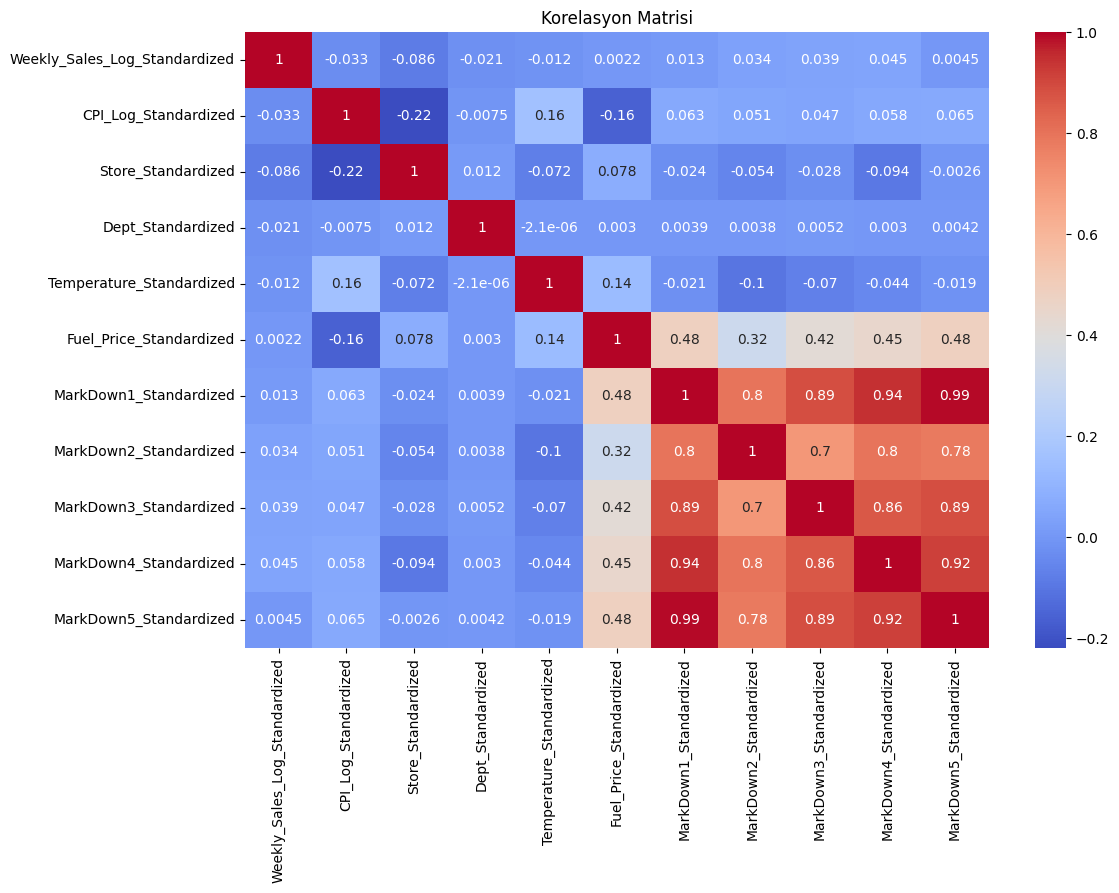

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
correlation_matrix = model_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Korelasyon Matrisi")
plt.show()


In [73]:
# Select the relevant features (keeping only MarkDown1 and MarkDown4 to reduce multicollinearity)
selected_features = [
    'Weekly_Sales_Log_Standardized',
    'CPI_Log_Standardized',
    'Store_Standardized',
    'Dept_Standardized',
    'Temperature_Standardized',
    'Fuel_Price_Standardized',
    'MarkDown1_Standardized',
    'MarkDown4_Standardized'
]

# Create a new DataFrame with the selected features
final_features = model_features[selected_features]

# Remove low-variance features (e.g., with a variance threshold of 0.01)
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
high_variance_features = selector.fit_transform(final_features)
selected_columns = final_features.columns[selector.get_support()]
optimized_features = final_features[selected_columns]

# Save the final feature set for modeling
optimized_features.to_csv('optimized_dataset.csv', index=False)
print("The dataset is saved as 'optimized_dataset.csv' and is ready for modeling.")



The dataset is saved as 'optimized_dataset.csv' and is ready for modeling.


# Code Explanation

This code prepares the dataset for modeling by performing the following steps:

1. **Feature Selection**: High-correlation features are filtered by selecting only `MarkDown1` and `MarkDown4` from the `MarkDown` variables, reducing potential multicollinearity issues.

2. **Low-Variance Feature Removal**: A `VarianceThreshold` of 0.01 is applied to eliminate features with low variance, which contribute little information to the model.

3. **Save Optimized Dataset**: The final set of features is saved as `optimized_dataset.csv`, ready for the modeling process.

This optimized dataset should offer a balance between reducing redundancy and retaining informative features for more effective modeling.


In [74]:
import os
file_path = "optimized_dataset.csv"
file_size = os.path.getsize(file_path)
file_size_mb = file_size / (1024 * 1024)
print(f"The size of the dataset is {file_size_mb:.2f} MB.")

The size of the dataset is 62.77 MB.
